# Load Data

In [1]:
import tensorflow as tf

# Load the Fashion MNIST dataset
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()

# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0

## Plot Data

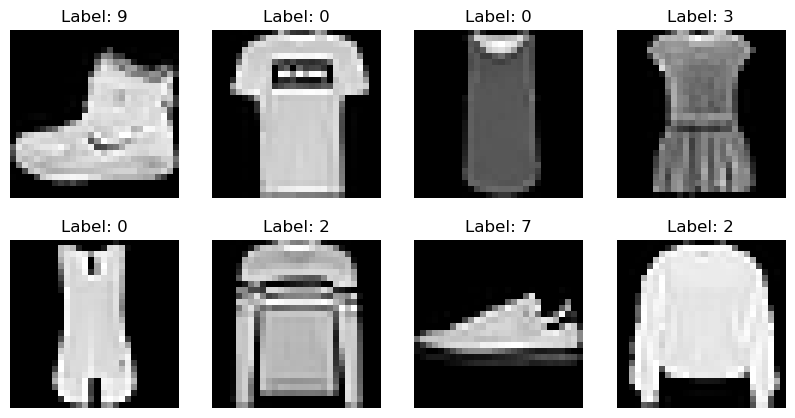

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')

plt.show()

In [3]:
# Check the shape of the data
# Each image is 28 x 28 pixels

print(x_train[1].shape)

(28, 28)


# Random Forest

## Data Prep

In [4]:
# Many machine learning models expect data to be in a 2D table, where each row is a sample and each column is a feature.
# We can flatten the 28x28 images into a single row of 784 pixels.

x_train_flat = x_train.reshape(x_train.shape[0], -1)
print(x_train_flat.shape)
print(y_train.shape)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

(60000, 784)
(60000,)


In [5]:
# Extract 7s and 9s from the training data (sneakers and ankle boots)
train_filter = (y_train == 7) | (y_train == 9)
x_train_7_9 = x_train_flat[train_filter]
y_train_7_9 = y_train[train_filter]

# Extract 7s and 9s from the test data
test_filter = (y_test == 7) | (y_test == 9)
x_test_7_9 = x_test_flat[test_filter]
y_test_7_9 = y_test[test_filter]

print(f'x_train_7_9 shape: {x_train_7_9.shape}')
print(f'y_train_7_9 shape: {y_train_7_9.shape}')
print(f'x_test_7_9 shape: {x_test_7_9.shape}')
print(f'y_test_7_9 shape: {y_test_7_9.shape}')

x_train_7_9 shape: (12000, 784)
y_train_7_9 shape: (12000,)
x_test_7_9 shape: (2000, 784)
y_test_7_9 shape: (2000,)


## Simple Model Fit

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200, random_state=42)

# Fit the model
rf.fit(x_train_7_9, y_train_7_9)

y_test_pred = rf.predict(x_test_7_9)

# Calculate the accuracy on the test data
test_accuracy = accuracy_score(y_test_7_9, y_test_pred)
print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.9595


# Tune Model Fit

In [22]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for mtry (max_features in sklearn)
param_grid = {
    'max_features': ['sqrt', 'log2'],
    'n_estimators': [100, 200, 300]
}

# Initialize the RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200, random_state=42)

# Initialize GridSearchCV with the RandomForestClassifier and the parameter grid
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(x_train_7_9, y_train_7_9)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best parameters: {best_params}')
print(f'Best cross-validation score: {best_score}')

# Use the best estimator to make predictions
best_rf = grid_search.best_estimator_
y_test_pred = best_rf.predict(x_test_7_9)

Best parameters: {'max_features': 'sqrt'}
Best cross-validation score: 0.96125


Test Accuracy: 0.9595
[[963  37]
 [ 44 956]]


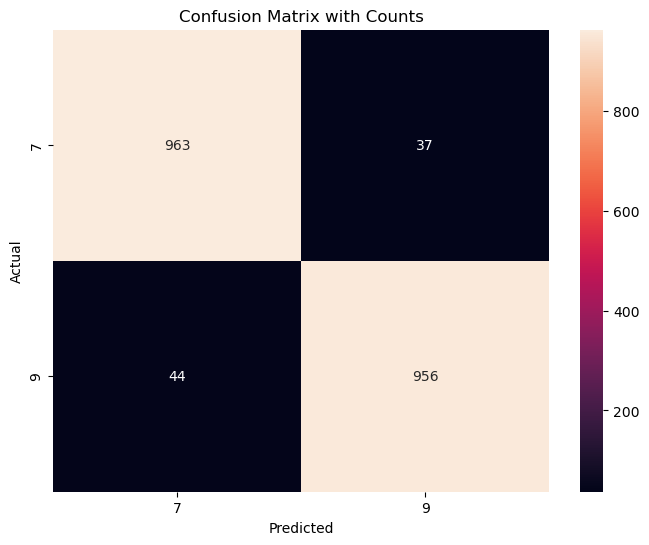

In [8]:
# Compute and plot a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# Calculate the accuracy on the test data
test_accuracy = accuracy_score(y_test_7_9, y_test_pred)
print(f'Test Accuracy: {test_accuracy}')

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_7_9, y_test_pred)
print(conf_matrix)

# Plot the confusion matrix with counts
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=[7, 9], yticklabels=[7, 9])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Counts')
plt.show()

In [10]:
y_test_pred_proba = rf.predict_proba(x_test_7_9)
print(y_test_pred_proba[:5])

[[0.13  0.87 ]
 [1.    0.   ]
 [0.975 0.025]
 [0.995 0.005]
 [0.425 0.575]]


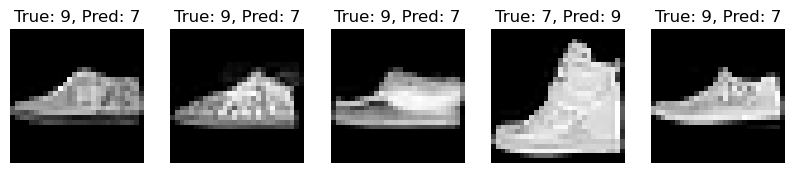

In [11]:
# Find the indices of misclassified samples
# Remember 7 is sneakers and 9 is ankle boots
misclassified_indices = [i for i in range(len(y_test_7_9)) if y_test_pred[i] != y_test_7_9[i]]

# Calculate the probabilities of the predicted class for misclassified samples
misclassified_probs = [y_test_pred_proba[idx][1] if y_test_7_9[idx] == 7 else y_test_pred_proba[idx][0] for idx in misclassified_indices]

# Get the indices of the 5 worst misclassifications (highest probabilities for the wrong class)
worst_misclassified_indices = [misclassified_indices[i] for i in sorted(range(len(misclassified_probs)), key=lambda i: misclassified_probs[i], reverse=True)[:5]]

# Plot the 5 worst misclassified samples
plt.figure(figsize=(10, 5))

for i, idx in enumerate(worst_misclassified_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_test_7_9[idx].reshape(28, 28), cmap='gray')
    plt.title(f'True: {y_test_7_9[idx]}, Pred: {y_test_pred[idx]}')
    plt.axis('off')

plt.show()

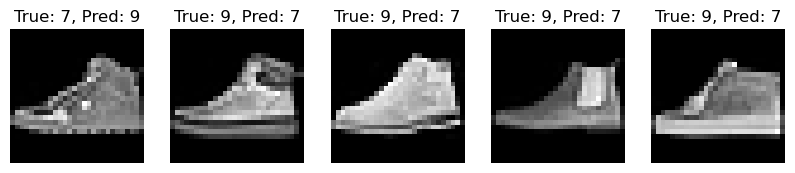

In [12]:
# Now get the 4 best misclassifications (lowest probabilities for the wrong class)

# Get the indices of the 5 best misclassifications (lowest probabilities for the wrong class)
best_misclassified_indices = [misclassified_indices[i] for i in sorted(range(len(misclassified_probs)), key=lambda i: misclassified_probs[i])[:5]]

# Plot the 4 best misclassified samples
plt.figure(figsize=(10, 5))

for i, idx in enumerate(best_misclassified_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_test_7_9[idx].reshape(28, 28), cmap='gray')
    plt.title(f'True: {y_test_7_9[idx]}, Pred: {y_test_pred[idx]}')
    plt.axis('off')

plt.show()